In [24]:
from config.config import cfg
from model.model import VisualGroundingModel
from data.dataset import VisualGroundingDataset
from data.preprocessor import PreProcessor


import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
import os


In [ ]:
from pytorch_lightning.utilities.deepspeed import (convert_zero_checkpoint_to_fp32_state_dict)
convert_zero_checkpoint_to_fp32_state_dict('../models/trained_models/best.ckpt', '/models/trained_models/model.ckpt',tag=None)

In [8]:
pl.seed_everything(cfg['training']['seed'])
distributed = cfg['training']['n_gpu'] > 1

Global seed set to 123


In [38]:
preprocessor = PreProcessor(cfg)    
train_dataset = VisualGroundingDataset('train', preprocessor)
valid_dataset = VisualGroundingDataset('valid', preprocessor)

train_loader = DataLoader(train_dataset, collate_fn=train_dataset.preprocessor.collate,
                               batch_size=cfg['training']['batch_size'], shuffle=False, num_workers=cfg['training']['num_workers'])
valid_loader = DataLoader(valid_dataset, collate_fn=valid_dataset.preprocessor.collate,
                               batch_size=cfg['training']['batch_size'], shuffle=False, num_workers=cfg['training']['num_workers'])


In [39]:
for i in train_loader:
    print(i[0].shape)
    break

torch.Size([8, 4, 512, 18, 18])


In [40]:
local_trained_model_path = os.path.join(
    cfg['training']['local_trained_model_path'], 'model.ckpt')
model = VisualGroundingModel.load_from_checkpoint(
    local_trained_model_path)

In [41]:
local_trained_model_path

'/models/trained_models/model.ckpt'

In [42]:
model

VisualGroundingModel(
  (text_features): TextualFeatures(
    (lstm_1): LSTM(1024, 512, batch_first=True, bidirectional=True)
    (lstm_2): LSTM(1024, 512, batch_first=True, bidirectional=True)
    (leaky_relu): LeakyReLU(negative_slope=0.25)
    (sentence_fc): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.25)
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): LeakyReLU(negative_slope=0.25)
    )
    (word_fc): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.25)
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): LeakyReLU(negative_slope=0.25)
    )
    (word_linear_comb): Linear(in_features=3, out_features=1, bias=False)
    (sentence_linear_comb): Linear(in_features=2, out_features=1, bias=False)
  )
  (visual_features): VisualFeatures(
    (0_conv_0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(

In [43]:
trainer = pl.Trainer(
            devices=cfg['training']['n_gpu'],
            accelerator="gpu",
            # strategy=self.cfg['training']['accelerator'] if self.distributed else None,
            strategy=None,
            accumulate_grad_batches=cfg['training']['accumulate_grad_batches'],
            max_epochs=cfg['training']['epochs'],
            default_root_dir=cfg['training']['local_trained_model_path'],
            log_every_n_steps=cfg['training']['log_every_n_steps']
        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name            | Type                | Params
--------------------------------------------------------
0 | text_features   | TextualFeatures     | 16.8 M
1 | visual_features | VisualFeatures      | 10.5 M
2 | attention       | MultimodalAttention | 0     
3 | loss            | MultimodalLoss      | 0     
--------------------------------------------------------
27.3 M    Trainable params
0         Non-trainable params
27.3 M    Total params
109.183   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                                                            | 0/2 [00:02<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   1%|▋                                                                                  | 1/120 [00:05<10:21,  5.22s/it, loss=2.73, v_num=1]

RuntimeError: CUDA out of memory. Tried to allocate 8.86 GiB (GPU 0; 31.71 GiB total capacity; 14.40 GiB already allocated; 8.79 GiB free; 19.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

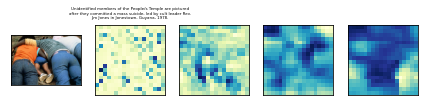

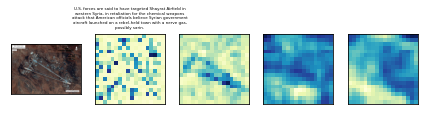

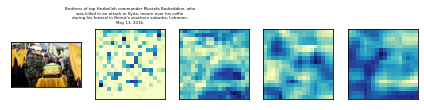

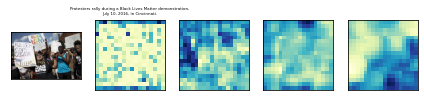

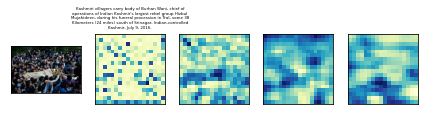

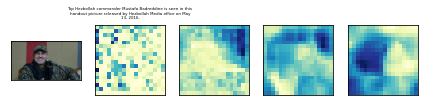

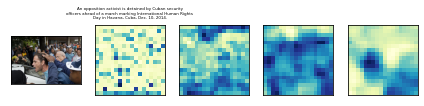

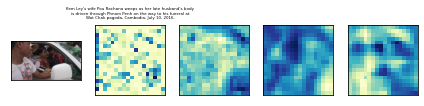

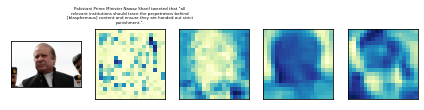

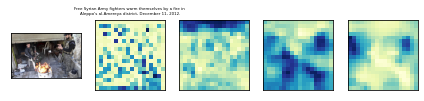

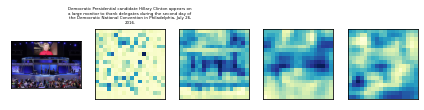

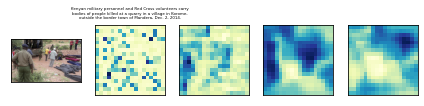

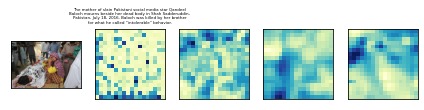

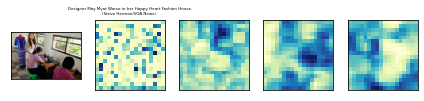

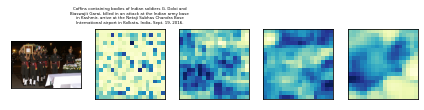

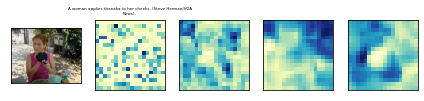

In [44]:
trainer.fit(model, train_loader, valid_loader)